# <font color=darkred> Random Monte-Carlo</font>

## <font color=darkblue> First-visit Monte-Carlo prediction problem with windy gridworld example</font>

Before, in simple first-visit Monte-carlo prediction problem, the transition probabilities and the policy were deterministic. Here, let's introduce randomness with this image of the wind that would push the agent in another direction than the one chosen with the deterministic policy. To do so, the function random_action() choses the action given by the deterministic policy with probability 0.5 and another random action with probability $0.5/3$. Hence, the transition probabilities are no longer deterministic. The goal is the prediction problem, so it is to find the value of every state s given the policy. 

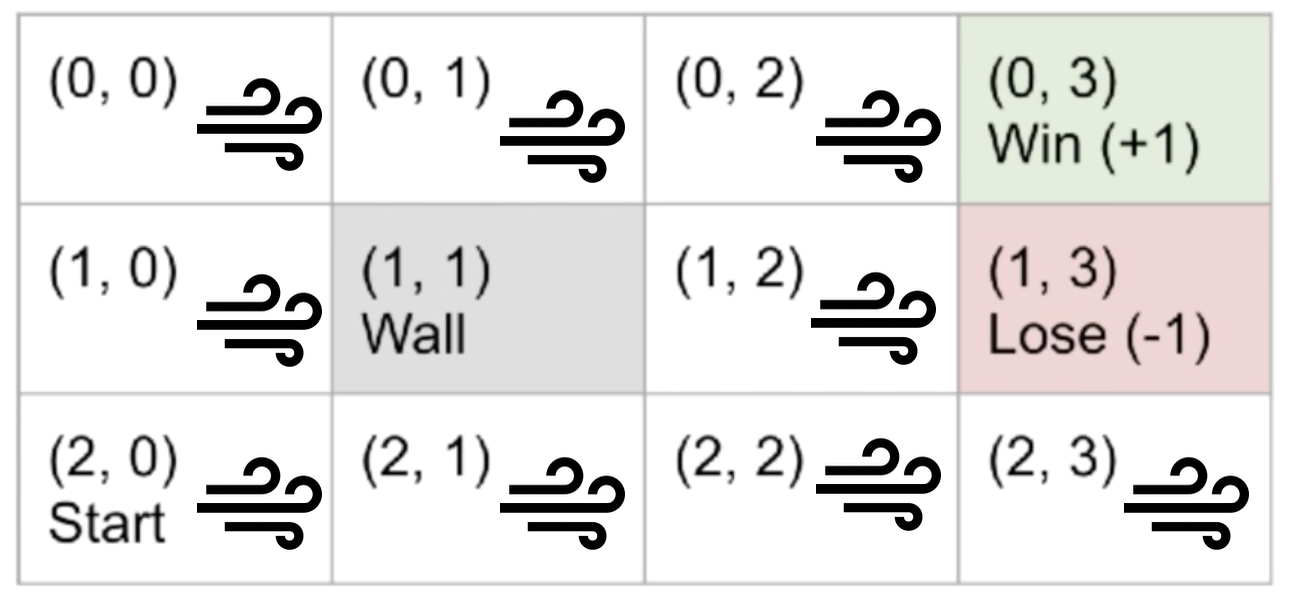

In [56]:
import numpy as np
import random
from copy import copy

In [57]:
class Gridworld:
    def __init__(self, row, col, start):
        self.rows=row
        self.cols=col
        self.i=start[0]
        self.j=start[1]
        
    def set(self, rewards, actions):
        self.reward = rewards
        self.action = actions
        
    #set the state to s for the gridworld object
    def set_state(self,s): 
        self.i=s[0]
        self.j=s[1]
    
    #returns the current state of the grid
    def current_state(self):
        return((self.i,self.j))
    
    #returns True if the state s is a terminal state (i.e: not in the action dictionnary)
    def is_terminal(self,s):
        return(s not in self.action.keys())
    
    #returns the coordonates of the next state given the action a 
    def get_next_state(self,s,a):
        i,j = s[0],s[1]
        #check if the action is permitted or not
        if a in self.action[(i,j)]:
            if a=='R':
                j+=1
            elif a=='L':
                j-=1
            elif a=='U':
                i-=1
            elif a=='D':
                i+=1
        return((i,j))
    
    #return the reward after the action was taking into account (by default reward is 0)
    def move(self,a):
        #check if the action is permitted or not
        s=self.current_state()
        i,j = s[0],s[1]
        if a in self.action[(i,j)]:
            if a=='R':
                self.j+=1
            elif a=='L':
                self.j-=1
            elif a=='U':
                self.i-=1
            elif a=='D':
                self.i+=1
        if (self.i,self.j) in self.reward.keys():
            return(self.reward[(self.i,self.j)])
        else:
            return(0)
        
    #return the modified grid when decide to step back one step before action a   
    def undo_move(self,a):
        if a=='R':
            self.j-=1
        elif a=='L':
            self.j+=1
        elif a=='U':
            self.i+=1
        elif a=='D':
            self.i-=1
        # raise an exception if we arrive somewhere we shouldn't be
        # should never happen
        assert(self.current_state() in self.all_states())
    
    def game_over(self):
        return((self.i,self.j) in self.reward)
    
    def all_states(self):
        return(set(self.action.keys() | self.reward.keys()))

In [58]:
def standard_grid():
    g = Gridworld(3,4,[2,0])
    rewards = {(0,3):+1,
              (1,3):-1}
    actions = {(0,0):('R','D'),
               (0,1):('R','L'),
               (0,2):('D','R','L'),
               (1,0):('U','D'),
               (1,2):('U','D','R'),
               (2,0):('U','R'),
               (2,1):('R','L'),
               (2,2):('U','R','L'),
               (2,3):('U','L')}
    g.set(rewards,actions)
    return(g)

In [59]:
def print_value(V,g):
    for i in range(g.rows):
        print("----------------------------")
        for j in range(g.cols):
            v = V.get((i,j),0)
            if v>=0:
                print(" %.2f |" %v, end="")
            else:
                print("%.2f |" %v, end="")
        print()

In [60]:
def print_policy(P,g):
    for i in range(g.rows):
        print("----------------")
        for j in range(g.cols):
            p = P.get((i,j),' ')
            print(" %s |" %p, end="")
        print()

In [61]:
### deterministic policy that becomes probabilistic with the random_action() function ###

P = {          (0,0):('R'),
               (0,1):('R'),
               (0,2):('R'),
               (1,0):('U'),
               (1,2):('U'),
               (2,0):('U'),
               (2,1):('R'),
               (2,2):('U'),
               (2,3):('L')}

ACTION_SPACE=['U','D','L','R']

gamma = 0.9

In [62]:
#This function takes action a chosen by policy with probability 0.5 and a random other one with a probability 0.5/3
def random_action(a):
    p = random.random()
    if p<0.5 : 
        return(a)
    else:
        list_actions = copy(ACTION_SPACE)
        del(list_actions[list_actions.index(a)])
        return(random.choice(list_actions))

In [54]:
#This function plays one episode of the game and returns the list of the visited states and their corresponding 
#returns
def play_game(grid, policy):
    
    #as we play with a deterministic policy, starting in the same position will lead to only calculate
    #the value of certain states because monte-carlo only cares about the states that are visited. So a random
    #initialization would lead to calculate the value of every state.
    possible_start = list(grid.action.keys()) #every possible starting position
    start_index = random.randint(0,len(possible_start)-1) #random choice of index sarting position 
    start_state = possible_start[start_index]
    
    #set the starting point of the game
    grid.set_state(start_state)
    
    #create the list of the states their corresponding rewards 
    s = grid.current_state()
    states_and_rewards = [(s,0)] #the starting point doesn't give any reward
    while not grid.game_over():
        a = policy[s]
        a = random_action(a) #wind can apply to any action
        r = grid.move(a)
        s = grid.current_state()
        states_and_rewards.append((s,r))
        
    #create the list of the states and their corresponding returns
    G=0
    states_and_returns = []
    for s, r in reversed(states_and_rewards):
        states_and_returns.append((s,G))
        G = gamma*G + r
    states_and_returns.reverse()
    #remove the last tuple which corresponds to the terminal state with a null return
    del(states_and_returns[-1]) 
    
    return(states_and_returns)

In [64]:
#initialize V(s) and all_returns which is a disctionnary. Keys are the states and values are the list of all the 
#returns for that corresponding state.

grid = standard_grid()
V={}
all_returns={}

for s in grid.all_states():
    if s in grid.action.keys():
        all_returns[s]=[]
    else:
        V[s]=0 #the value of a terminal state is null
        
print("The policy chosen is the following one : ")
print_policy(P,grid)
print()

for t in range(100):
    states_and_returns = play_game(grid,P) #one episode of the game played
    seen_states = []
    for (s,g) in states_and_returns:
        if s not in seen_states : 
            all_returns[s].append(g)
            seen_states.append(s)
            V[s]=np.mean(all_returns[s])

print("The value table found with monte-carlo method is the following one : ")
print_value(V,grid)

The policy chosen is the following one : 
----------------
 R | R | R |   |
----------------
 U |   | U |   |
----------------
 U | R | U | L |

The value table found with monte-carlo method is the following one : 
----------------------------
 0.37 | 0.53 | 0.75 | 0.00 |
----------------------------
 0.26 | 0.00 | 0.23 | 0.00 |
----------------------------
 0.29 | 0.18 | 0.08 |-0.15 |
